In [2]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import time
#from datetime import datetime, timedelta
#from dateutil import tz

import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

In [3]:
# function to merge dataframes
def merge_dfs(basepath, years, pitchers, use_cols=[]):
    """
    iterate through list of pitchers of interest for each year in list to open play-by-play file
    then merge play-by-play data into a single dataframe
    
    returns merged dataframe
    """
    # path to pitcher_ids.csv file
    pitcher_ids_path = 'data/pitcher_logs/pitcher_ids.csv'
    # open pitcher_ids.csv file, set 'id' as index
    df_pitcher_ids = pd.read_csv(pitcher_ids_path, index_col='id')
    
    # list to store paths to each players play-by-play csv files
    filelist = []
    
    # iterate through list of pitchers for each year and gather file paths and pitcher names
    for year in years:
        for pitcher in pitchers:         
            file_path = basepath + '/' + year + '/merged_by_player/' + pitcher + '_' + year + '_merged_games.csv'
            f_name, l_name = pitcher.split(sep='_')
            filelist.append(file_path)
            
    # work with first pitcher in list to store in initial dataframe then remove pitcher from list
    first_file = filelist.pop(0)
    if len(use_cols)==0:
        df = pd.read_csv(first_file)
        ids = df['pitcher.id'].iloc[0]
        df['pitcher.first_name'] = df_pitcher_ids.at[ids, 'preferred_name']
        df['pitcher.last_name'] = df_pitcher_ids.at[ids, 'last_name']
    else:
        df = pd.read_csv(first_file, usecols=use_cols)
        ids = df['pitcher.id'].iloc[0]
        df['pitcher.first_name'] = df_pitcher_ids.at[ids, 'preferred_name']
        df['pitcher.last_name'] = df_pitcher_ids.at[ids, 'last_name']
    
    # work with remaining pitchers in list to concatenate data with previous dataframe
    for file in filelist:
        if len(use_cols)==0:
            # open merged_games.csv file for each player
            df_temp = pd.read_csv(file)
            ids = df_temp['pitcher.id'].iloc[0]
            df_temp['pitcher.first_name'] = df_pitcher_ids.at[ids, 'preferred_name']
            df_temp['pitcher.last_name'] = df_pitcher_ids.at[ids, 'last_name']
        else: # use only if specific columns requested
            # open merged_games.csv file for each player
            df_temp = pd.read_csv(file, usecols=use_cols)
            ids = df_temp['pitcher.id'].iloc[0]
            df_temp['pitcher.first_name'] = df_pitcher_ids.at[ids, 'preferred_name']
            df_temp['pitcher.last_name'] = df_pitcher_ids.at[ids, 'last_name']
            
        df = pd.concat([df, df_temp], ignore_index=True, sort=False)
    print("merge_dfs(...) completed.\n")
    return df

In [4]:
# base path with subfolders for each pitcher of interest
basepath = 'data/pbp_files'

# list of years to clean and merge play-by-play data
years = ['2016', '2017', '2018']

# list of pitchers of interest
pitchers = ['aaron_nola', 'carlos_carrasco', 'carlos_martinez', 'chris_archer', 'chris_sale', 
            'clayton_kershaw', 'corey_kluber', 'dallas_keuchel', 'david_price', 'gerrit_cole',
            'jacob_degrom', 'jake_arrieta', 'jose_quintana', 'marcus_stroman', 'justin_verlander', 
            'max_scherzer', 'michael_fulmer', 'stephen_strasburg', 'yu_darvish', 'zack_greinke']

In [5]:
# call to merge play-by-play data into single dataframe for player's of interest (poi)
df_merged = merge_dfs(basepath, years, pitchers)
# rename some pitch types that are too similar to distinguish 
# such as sinkers -> fastball, split-finger curve -> curveball, and forkball -> splitter
df_merged.replace({'FA': 'FB', 'SI': 'FB', 'CU': 'CB', 'SC': 'CB', 'SP': 'SF', 'FO': 'SF'}, inplace=True)

merge_dfs(...) completed.



In [6]:
df_merged['full_name'] = df_merged['pitcher.first_name'] + " " + df_merged['pitcher.last_name']
df_merged.drop(columns=['pitcher.first_name', 'pitcher.last_name', 'Empty'], inplace=True)

In [7]:
# general list of similar columns grouped for pitchers of interest dataframe
count_cols = ['count.balls','count.strikes','count.pitch_count']
pitch_cols = ['pitcher.pitch_type','pitcher.pitch_speed','pitcher.pitch_count','pitcher.pitch_zone','outcome_id']
flags_cols = ['flags.is_ab_over', 'flag.is_bunt_shown', 'flag.is_hit', 'flag.is_passed_ball']
pitcher_cols = ['full_name', 'pitcher.pitcher_hand', 'pitcher.hitter_hand', 'pitcher.id']
runner_cols = ['runner_1.starting_base', 'runner_1.ending_base', 'runner_1.outcome_id', 
               'runner_2.starting_base', 'runner_2.ending_base', 'runner_2.outcome_id', 
               'runner_3.starting_base', 'runner_3.ending_base', 'runner_3.outcome_id', 
               'runner_4.starting_base', 'runner_4.ending_base', 'runner_4.outcome_id']
date_cols = ['year', 'month', 'day']
inning_cols = ['inning', 'half']

# list of top or most interesting outcome id's to explore
outcomes = ['dB', 'kKL', 'kF', 'kKS', 'oGO', 'aS', 'oFO', 'oLO', 'aD', 'oPO', 'bDB', 'kFT', 'aHR', 'oFC', 'aT']

In [8]:
pd.unique(df_merged['full_name'])

array(['Aaron Nola', 'Carlos Carrasco', 'Carlos Martinez', 'Chris Archer',
       'Chris Sale', 'Clayton Kershaw', 'Corey Kluber', 'Dallas Keuchel',
       'David Price', 'Gerrit Cole', 'Jacob deGrom', 'Jake Arrieta',
       'Jose Quintana', 'Marcus Stroman', 'Justin Verlander',
       'Max Scherzer', 'Michael Fulmer', 'Stephen Strasburg',
       'Yu Darvish', 'Zack Greinke'], dtype=object)

In [9]:
df_merged['hit_type']=df_merged['hit_type'].fillna('NH')

In [21]:
df_merged[['pitcher.pitch_type', 'hit_type', 'outcome_id']].head(12)

,pitcher.pitch_type,hit_type,outcome_id
0,FB,NH,kKL
1,FB,NH,kF
2,CB,GB,oGO
3,FB,NH,bB
4,FB,NH,aHR
5,FB,NH,kKL
6,FB,NH,bB
7,CB,NH,kF
8,CB,NH,kF
9,FB,NH,bB


In [22]:
pd.unique(df_merged['hit_type'])

array(['NH', 'GB', 'LD', 'PU', 'FB'], dtype=object)

In [23]:
# transform and map pokemon generations
gen_le = LabelEncoder()
gen_labels = gen_le.fit_transform(df_merged['hit_type'])
df_merged['hitType_label'] = gen_labels

# transform and map pokemon legendary status
leg_le = LabelEncoder()
leg_labels = leg_le.fit_transform(df_merged['outcome_id'])
df_merged['outcome_label'] = leg_labels
df_sub = df_merged[date_cols + inning_cols + count_cols + pitch_cols + ['hitType_label', 'outcome_label']]
df_sub.head()

,year,month,day,inning,half,count.balls,count.strikes,count.pitch_count,pitcher.pitch_type,pitcher.pitch_speed,pitcher.pitch_count,pitcher.pitch_zone,outcome_id,hitType_label,outcome_label
0,2016,4,6,1.0,B,0.0,1.0,1.0,FB,91.0,1.0,6.0,kKL,3,29
1,2016,4,6,1.0,B,0.0,2.0,2.0,FB,89.0,2.0,7.0,kF,3,27
2,2016,4,6,1.0,B,0.0,2.0,3.0,CB,77.0,3.0,7.0,oGO,1,35
3,2016,4,6,1.0,B,1.0,0.0,1.0,FB,91.0,4.0,13.0,bB,3,23
4,2016,4,6,1.0,B,1.0,0.0,2.0,FB,89.0,5.0,5.0,aHR,3,7


In [24]:
# encode generation labels using one-hot encoding scheme
gen_ohe = OneHotEncoder()
gen_feature_arr = gen_ohe.fit_transform(df_merged[['hitType_label']]).toarray()
gen_feature_labels = list(gen_le.classes_)
gen_features = pd.DataFrame(gen_feature_arr, columns=gen_feature_labels)

# encode legendary status labels using one-hot encoding scheme
leg_ohe = OneHotEncoder()
leg_feature_arr = leg_ohe.fit_transform(df_merged[['outcome_label']]).toarray()
leg_feature_labels = [str(cls_label) for cls_label in leg_le.classes_]
leg_features = pd.DataFrame(leg_feature_arr, columns=leg_feature_labels)

In [27]:
poke_df_ohe = pd.concat([df_sub, gen_features, leg_features], axis=1)
columns = sum([['pitcher.pitch_type','hitType_label'], gen_feature_labels, ['outcome_label'], leg_feature_labels], [])
poke_df_ohe[columns].head(12)

,pitcher.pitch_type,hitType_label,FB,GB,LD,NH,PU,outcome_label,aBK,aCI,...,oFO,oGO,oKST1,oKST2,oLO,oPO,oROET2,oSB,oSF,oST2
0,FB,3,0.0,0.0,0.0,1.0,0.0,29,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FB,3,0.0,0.0,0.0,1.0,0.0,27,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CB,1,0.0,1.0,0.0,0.0,0.0,35,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,FB,3,0.0,0.0,0.0,1.0,0.0,23,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,FB,3,0.0,0.0,0.0,1.0,0.0,7,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,FB,3,0.0,0.0,0.0,1.0,0.0,29,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,FB,3,0.0,0.0,0.0,1.0,0.0,23,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,CB,3,0.0,0.0,0.0,1.0,0.0,27,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,CB,3,0.0,0.0,0.0,1.0,0.0,27,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,FB,3,0.0,0.0,0.0,1.0,0.0,23,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
poke_df_ohe[columns].describe()

,hit_label,FB,GB,LD,NH,PU,outcome_label,aBK,aCI,aD,...,oFO,oGO,oKST1,oKST2,oLO,oPO,oROET2,oSB,oSF,oST2
count,167427.000000,167427.000000,167427.000000,167427.000000,167427.000000,167427.000000,167427.000000,167427.000000,167427.000000,167427.000000,...,167427.000000,167427.000000,167427.000000,167427.000000,167427.000000,167427.000000,167427.000000,167427.000000,167427.000000,167427.000000
mean,2.721759,0.034481,0.074719,0.037628,0.840904,0.012268,26.390660,0.000143,0.000054,0.010697,...,0.026394,0.054585,0.000179,0.000006,0.015069,0.011796,0.000012,0.001027,0.001171,0.000376
std,0.762683,0.182461,0.262938,0.190296,0.365767,0.110080,5.755936,0.011972,0.007332,0.102873,...,0.160303,0.227169,0.013385,0.002444,0.121829,0.107968,0.003456,0.032035,0.034195,0.019394
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,23.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,27.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,29.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,43.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
df_aNola = df_merged[df_merged['full_name']=='Aaron Nola']
df_aNola_2016 = df_aNola[(df_aNola['year']==2016)]
df_aNola_2016.dropna(axis=1, how='all', inplace=True)
df_aNola_2017 = df_aNola[(df_aNola['year']==2017)]
df_aNola_2017.dropna(axis=1, how='all', inplace=True)
df_aNola_2018 = df_aNola[(df_aNola['year']==2018)]
df_aNola_2018.dropna(axis=1, how='all', inplace=True)

In [145]:
df_aNola_2016_features = df_aNola_2016[date_cols + inning_cols + count_cols + pitch_cols + pitcher_cols]

In [167]:
df_aNola_2016_game01 = df_aNola_2016_features[(df_aNola_2016_features['month']==4)]
df_aNola_2016_game01 = df_aNola_2016_game01[(df_aNola_2016_game01['day']==6)]

In [181]:
df_aNola.groupby(['outcome_id', 'pitcher.pitch_type'])['pitcher.pitch_type'].agg(['count']).sort_values('count')

,,count
outcome_id,pitcher.pitch_type,
aBK,UN,1
oSB,CH,1
oGO,SL,1
kKL,SL,1
kF,UN,1
aHBP,CH,1
aKSAD1,FB,1
aSAD2,CH,1
aROEAD2,CH,1


In [182]:
df_aNola_2016_game01_copy = df_aNola.copy()
df_aNola_2016_game01_copy['prev.outcome_id'] = df_aNola_2016_game01_copy['outcome_id'].shift(-1)
df_aNola_2016_game01_copy

,count.balls,count.outs,count.pitch_count,count.strikes,day,description,errors,flags.is_ab_over,flags.is_bunt,flags.is_bunt_shown,...,weather.current_conditions.cloud_cover,weather.current_conditions.condition,weather.current_conditions.dew_point_f,weather.current_conditions.humidity,weather.current_conditions.obs_time,weather.current_conditions.temp_f,weather.current_conditions.wind.direction,weather.current_conditions.wind.speed_mph,full_name,prev.outcome_id
0,0.0,0.0,1.0,1.0,6,"Zack Cozart grounds out to third base, Maikel ...",NaN,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aaron Nola,kF
1,0.0,0.0,2.0,2.0,6,"Zack Cozart grounds out to third base, Maikel ...",NaN,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aaron Nola,oGO
2,0.0,1.0,3.0,2.0,6,"Zack Cozart grounds out to third base, Maikel ...",NaN,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aaron Nola,bB
3,1.0,1.0,1.0,0.0,6,Eugenio Suarez homers to center field.,NaN,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aaron Nola,aHR
4,1.0,1.0,2.0,0.0,6,Eugenio Suarez homers to center field.,NaN,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aaron Nola,kKL
5,0.0,1.0,1.0,1.0,6,Joey Votto grounds out to first base to Darin ...,NaN,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aaron Nola,bB
6,1.0,1.0,2.0,1.0,6,Joey Votto grounds out to first base to Darin ...,NaN,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aaron Nola,kF
7,1.0,1.0,3.0,2.0,6,Joey Votto grounds out to first base to Darin ...,NaN,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aaron Nola,kF
8,1.0,1.0,4.0,2.0,6,Joey Votto grounds out to first base to Darin ...,NaN,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aaron Nola,bB
9,2.0,1.0,5.0,2.0,6,Joey Votto grounds out to first base to Darin ...,NaN,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aaron Nola,oGO


In [184]:
df_aNola_2016_game01_copy.groupby(['prev.outcome_id'])['pitcher.pitch_type'].agg(['count']).sort_values('count')

,count
prev.outcome_id,
aBK,1
aKSAD1,1
aSBAD1,2
oST2,2
aROEAD2,3
aIBB,5
aSAD2,5
bIB,7
oSF,8


In [204]:
df_merged[df_merged['outcome_id'].isin(outcomes)].groupby(['outcome_id', 'pitcher.pitch_type'])['pitcher.pitch_type'].count()

outcome_id  pitcher.pitch_type
aD          CB                     185
            CH                     195
            CT                      89
            FB                    1033
            SL                     289
aHR         CB                     125
            CH                     123
            CT                      56
            FB                     673
            SF                       1
            SL                     215
aS          CB                     567
            CH                     718
            CT                     233
            FB                    3224
            SF                       1
            SL                     991
            UN                       1
aT          CB                      14
            CH                      22
            CT                       8
            FB                      95
            SL                      23
bDB         CB                     847
            CH                   

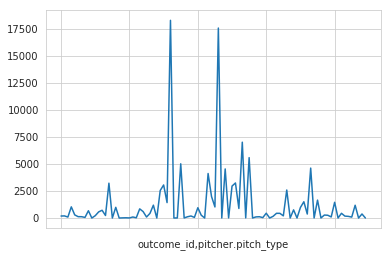

In [205]:
df_merged[df_merged['outcome_id'].isin(outcomes)].groupby(['outcome_id', 'pitcher.pitch_type'])['pitcher.pitch_type'].count().plot()

In [147]:
print(df_merged.isnull().sum())

count.balls                                       0
count.outs                                        0
count.pitch_count                                 0
count.strikes                                     0
day                                               0
description                                     318
errors                                       166859
flags.is_ab_over                                  0
flags.is_bunt                                     0
flags.is_bunt_shown                               0
flags.is_double_play                              0
flags.is_hit                                      0
flags.is_passed_ball                              0
flags.is_triple_play                              0
flags.is_wild_pitch                               0
half                                              0
hit_location                                 138391
hit_type                                     140790
hitter.first_name                             25878
hitter.id   

In [152]:
pd.unique(df_merged['pitcher.pitch_type'])

array(['FB', 'CB', 'CH', 'SL', 'IB', 'UN', 'SF', 'PI', 'CT', 'KN'],
      dtype=object)

In [149]:
df = df_aNola_2016[['count.balls', 'count.strikes', 'pitcher.pitch_type']]

In [150]:
df['prev.pitch_type'] = df['pitcher.pitch_type'].shift(-1)
#df['prev.prev_pitch_type'] = df['pitcher.pitch_type'].shift(-2)
#df['prev.prev_prev_pitch_type'] = df['pitcher.pitch_type'].shift(-3)

In [151]:
df.groupby(['pitcher.pitch_type', 'prev.pitch_type']).count().sort_values('count.balls')

count.balls  count.strikes
pitcher.pitch_type prev.pitch_type                            
CB                 IB                         1              1
FB                 IB                         2              2
                   SL                         2              2
SL                 FB                         2              2
IB                 CB                         3              3
                   IB                         4              4
CH                 CH                        21             21
                   CB                        35             35
CB                 CH                        40             40
FB                 CH                        92             92
CH                 FB                        97             97
CB                 CB                       222            222
                   FB                       344            344
FB                 CB                       348            348
                   FB                       586            586

In [153]:
replace_map = {'pitcher.pitch_type': {'FB':1,'CB':2,'CH':3,'SL':4,'IB':5,'UN':6,'SF':7,'PI':8,'CT':9,'KN':10}}

In [159]:
df_replaced = df_merged.copy()
df_replaced.replace(replace_map, inplace=True)
df_replaced['pitcher.pitch_type'] = df_replaced['pitcher.pitch_type'].astype('category')
df_replaced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167427 entries, 0 to 167426
Data columns (total 69 columns):
count.balls                                  167427 non-null float64
count.outs                                   167427 non-null float64
count.pitch_count                            167427 non-null float64
count.strikes                                167427 non-null float64
day                                          167427 non-null int64
description                                  167109 non-null object
errors                                       568 non-null object
flags.is_ab_over                             167427 non-null bool
flags.is_bunt                                167427 non-null bool
flags.is_bunt_shown                          167427 non-null bool
flags.is_double_play                         167427 non-null bool
flags.is_hit                                 167427 non-null bool
flags.is_passed_ball                         167427 non-null bool
flags.is_triple_p